In [58]:
import acoular
import matplotlib.pyplot as pl
import ipywidgets as ipw
import numpy as np
from glob import glob
from os import path
import pylab as plt
import math as m
import mpl_toolkits.mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sc


In [59]:
# Einlesen der Micgeo
micgeofile = 'mic_geo.xml'
mg = acoular.MicGeom(from_file=micgeofile)
mg.mpos[0] = - mg.mpos[0] #Spiegeln
mg.mpos[0] = mg.mpos[0] + 0.419 #Versatz
#print(mg.mpos)

# Rotationsmatrix
def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                    [ 0, m.cos(theta),-m.sin(theta)],
                    [ 0, m.sin(theta), m.cos(theta)]])
                   
for i in range (64):
    Punkt = [mg.mpos[0][i],mg.mpos[1][i],mg.mpos[2][i]]
    rot = np.array(Punkt * Rx(np.radians(-40))) # radians -> rotation angle 
    #print(rot[0][0])
    mg.mpos[0][i] = rot[0][0]
    mg.mpos[1][i] = rot[0][1]
    mg.mpos[2][i] = rot[0][2]
mg.mpos[1] = - mg.mpos[1]

# plt.ion()
#plt.plot(mg.mpos[2],mg.mpos[1],'o')

# Umgebung definieren (Medium, Strömung etc)
t = 23.6
e = acoular.Environment(c = 20.05*np.sqrt(273+t))

Einlesen der Daten:

In [339]:
#Simuliertes Signal erzeugen
sfreq = 51200
duration = 1
nsamples = duration*sfreq

sim_signal1 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)
sim_signal2 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=2)

sim_signal = acoular.SineGenerator(sample_freq = sfreq,   # Abtastfrequenz
                     numsamples = nsamples,     # Anzahl der Samples, entspricht Messzeit (hier extrem kurz)
                     freq = 800,           # Sinusfrequenz
                     amplitude = 1.)     

sim_ts1 = acoular.PointSource(signal = sim_signal1,          # Signal der Quelle
                   loc = (0, 0, 2.0),  # Position der Punktquelle im links-orientierten Koordinatensystem
                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
#sim_ts2 = acoular.PointSource(signal = sim_signal2,          # Signal der Quelle
#                   loc = (-5.0, 0, 1.5),  # Position der Punktquelle im links-orientierten Koordinatensystem
#                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
#                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
ts = acoular.SourceMixer( sources=[sim_ts1])
'''
sim_signal1 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)

ts = acoular.PointSource(signal = sim_signal1,          # Signal der Quelle
                   loc = (0, 0.2, 10.0),  # Position der Punktquelle im links-orientierten Koordinatensystem
                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
'''

'\nsim_signal1 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)\n\nts = acoular.PointSource(signal = sim_signal1,          # Signal der Quelle\n                   loc = (0, 0.2, 10.0),  # Position der Punktquelle im links-orientierten Koordinatensystem\n                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen\n                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet\n'

In [326]:
#Einlesen der Daten:
#ts = acoular.TimeSamples( name='Messungen WFS\msm_025.h5' )
ts = acoular.TimeSamples( name='Messungen_WFS/msm_025.h5' )
ts 

In [340]:
#Grid erstellen

focus_plane = 2
x_range = 3     # times two -> around 0
y_range = 2     # times two -> around 0
z_range = 6     # from 0
incrmt = 0.02
blocksize = 4096
f_min = 100
f_max = 22000

rg = acoular.RectGrid3D(x_min=-x_range, x_max=x_range, 
                       y_min=-y_range, y_max=y_range, 
                       z_min=focus_plane, z_max=focus_plane, 
                       increment=incrmt)
              
#Steering Vector
st = acoular.SteeringVector( grid=rg, 
                             mics=mg, 
                             #ref=1,     # Tipp von Gert, ref auf 1m, stimmt das so? Und wieso?
                             env = e,
                             steer_type = 'true location') # ???

#Spectrum erstellen:
ps = acoular.PowerSpectra( time_data=ts, 
                           block_size=blocksize,
                           freq_range=[f_min, f_max],
                           window='Hanning' ) # Für bessere Auflösung hier Block_size erhöhen -> höherer Rechnenaufwand, daher jetzt erstmal mit 128


bb = acoular.BeamformerBase( freq_data=ps, 
                             steer=st )

                             #Grid erstellen

 #=================== TOP VIEW =====================                            
rg2 = acoular.RectGrid3D(x_min=-x_range, x_max=x_range, 
                       y_min=0, y_max=0, 
                       z_min=0, z_max=z_range, 
                       increment=incrmt)

#Steering Vector
st2 = acoular.SteeringVector(grid=rg2, 
                             mics=mg, 
                             #ref=1,     # Tipp von Gert, ref auf 1m, stimmt das so? Und wieso?
                             env = e,
                             steer_type = 'true location') # ???

#Spectrum erstellen:
ps2 = acoular.PowerSpectra(time_data=ts, 
                           block_size=blocksize,
                           freq_range=[f_min, f_max],
                           window='Hanning' ) # Für bessere Auflösung hier Block_size erhöhen -> höherer Rechnenaufwand, daher jetzt erstmal mit 128


bb2 = acoular.BeamformerBase(freq_data=ps2, 
                             steer=st2 )





In [379]:
# 200 250 315 400 500 630 800 1000 1250 1600 2000 2500 3150 4000 5000 6300 8000 10000 12500 16000 20000

bandwidth_dict = {
  "Freq": 0,
  "Okt": 1,
  "Terz": 3
}

bandwith = 'Terz'
Frequenz =  12500
tolerance = 10
pm = bb.synthetic(Frequenz, bandwidth_dict[bandwith])
pm2 = bb2.synthetic(Frequenz, bandwidth_dict[bandwith])
 # 0=Freq, 1=Okt, 3=Terz

Quellposition xy bei x = [0.] / y = [0.]
79.8047392799122


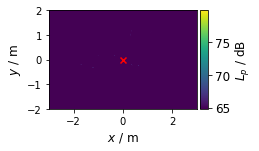

In [380]:
FONTSIZE = 12
fig=plt.figure(1,(3.7,2.8))
map_z = np.sum(pm,2)
mx = acoular.L_p(map_z.max())
Lm_z = acoular.L_p(map_z)
max_pegel_z = max_pegel(Lm_z, tolerance)
x_coord_max_front = np.where(Lm_z.T == max_pegel_z[0])[1]*rg.increment-((rg.x_max-rg.x_min)/2)
y_coord_max_front = np.where(Lm_z.T == max_pegel_z[0])[0]*rg.increment-((rg.y_max-rg.y_min)/2)
im = plt.imshow(acoular.L_p(map_z.T), 
           vmax=mx, 
           vmin=mx-15, 
           origin='lower', 
           interpolation='nearest', 
           extent=(rg.x_min, rg.x_max, rg.y_min, rg.y_max))
#plt.scatter(0, 0, c='C0',  marker = 'o')
if (len(max_pegel_z) > 0):
    plt.scatter(x_coord_max_front, y_coord_max_front,  c='red',  marker = 'x')
    print(f'Quellposition xy bei x = {x_coord_max_front} / y = {y_coord_max_front}')
#if (len(max_pegel_z) > 1):
#    for i in range(1,len(max_pegel_z)):
#        x_coord_max_front_sec = np.where(Lm_z.T == max_pegel_z[i])[1]*rg.increment-((rg.x_max-rg.x_min)/2)
#        y_coord_max_front_sec = np.where(Lm_z.T == max_pegel_z[i])[0]*rg.increment-((rg.y_max-rg.y_min)/2)    
#        plt.scatter(x_coord_max_front_sec, y_coord_max_front_sec, c='white',  marker = 'x')
plt.xlabel('$x$ / m',fontsize=FONTSIZE)
plt.ylabel('$y$ / m',fontsize=FONTSIZE)
#plt.title('Front view (xy)' )

ax = plt.gca()
divider = make_axes_locatable(ax)   
cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=FONTSIZE)
cbar.set_label('$L_p$ / dB', fontsize=FONTSIZE)
print(np.max(Lm_z))
plt.tight_layout()
#plt.savefig('Plots/Praesi/%s_%s%dHz_front.png'%(ts.name[14:21],bandwith,Frequenz), dpi = 300, format='png')
plt.savefig('Plots/Praesi/Simuliert_%s%dHz_front.png'%(bandwith,Frequenz), dpi = 300, format='png')


Quellposition xz bei x = [0.08] / z = [0.94]
53.12531143768502


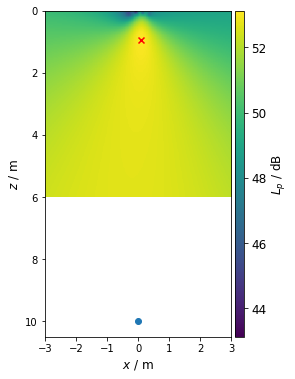

In [191]:
fig = plt.figure(figsize=(6,6))
map_y = np.sum(pm2,1)
if (rg2.y_min == rg2.y_max):
    mx = acoular.L_p(map_y.max())
Lm_y = acoular.L_p(map_y)

max_pegel_y = max_pegel(Lm_y, tolerance) 
x_coord_max_top = np.where(Lm_y.T == max_pegel_y[0])[1]*rg2.increment-((rg2.x_max-rg2.x_min)/2)
y_coord_max_top = np.where(Lm_y.T == max_pegel_y[0])[0]*rg2.increment
im = plt.imshow(acoular.L_p(map_y.T), 
           vmax=mx, 
           vmin=mx-10, 
           origin='upper', 
           interpolation='nearest', 
           extent=(rg2.x_min, rg2.x_max, rg2.z_max, rg2.z_min))
plt.scatter(0, 10, c='C0',  marker = 'o')
plt.scatter(x_coord_max_top, y_coord_max_top, c='red',  marker = 'x')
print(f'Quellposition xz bei x = {x_coord_max_top} / z = {y_coord_max_top}')

# Position of expected virtual sound source
plt.xlabel('$x$ / m',fontsize=FONTSIZE)
plt.ylabel('$z$ / m',fontsize=FONTSIZE)
#plt.title('Top view (xz)' )

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=FONTSIZE)
cbar.set_label('$L_p$ / dB', fontsize=FONTSIZE)

#print(max_pegel_y[0])
print(np.max(Lm_y))
#print(np.where(Lm_y.T == max_pegel_y[0]))

#plt.savefig('Plots/Praesi/%s_%s%dHz_top.png'%(ts.name[14:21],bandwith,Frequenz), dpi = 300, format='png')
#plt.savefig('Plots/Praesi/Simulation_%s%dHz_top.png'%(bandwith,Frequenz), dpi = 300, format='png')


In [66]:
# function calculates max calues of given array
def max_pegel (Lm, tol = 10):
    Lm_max = sc.signal.argrelmax(Lm)
    Lm_rot = np.rot90(Lm)#rotiert Lm um 90 Grad
    Lm_rot_max = sc.signal.argrelmax(Lm_rot)

    max_values = []
    for i in range (len(Lm_max[0])):
        max_value = Lm[Lm_max[0][i]][Lm_max[1][i]]

        if (max_value >= np.amax(Lm.T) - tol):
            max_values.append(max_value)
    max_values = np.array(max_values)

    max_values_rot = []
    for i in range (len(Lm_rot_max[0])):
        max_value_rot  = Lm_rot[Lm_rot_max[0][i]][Lm_rot_max[1][i]]

        if (max_value_rot  >= np.amax(Lm.T) - tol):
            max_values_rot .append(max_value_rot)
    max_values_rot  = np.array(max_values_rot)

    max_pegel  = []
    for i in range (len(max_values)):

        if (max_values [i] in max_values_rot):
            max_pegel .append(max_values[i])
    max_pegel  = np.sort(max_pegel)      
    max_pegel  = max_pegel[::-1]
    return max_pegel

In [67]:
#if (len(max_pegel_y) > 1):
    #for i in range(1,len(max_pegel_y)):
        #plt.scatter(np.where(Lm_y.T == max_pegel_y[i])[1]*rg2.increment-((rg2.x_max-rg2.x_min)/2), np.where(Lm_y.T == max_pegel_y[i])[0]*rg2.increment,  c='white',  marker = 'x')